In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [2]:
%%capture
%run -i -e Pair_Selection.ipynb

In [3]:
# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)

Top 10 pairs with highest correlation and cointegration:
('AWK', 'NEE', 0.9868568115394872, 0.0021702962443593287, 0.8875227705044594, 0.00047915622637524516)
('ES', 'WEC', 0.9805179496276685, 0.0024463386112988073, 0.004369302557719054, 0.000846420301143742)
('CFG', 'RF', 0.9823147370618126, 0.013898508852412044, 0.5308970589810956, 0.0006392880800180128)
('DTE', 'PEG', 0.9673594718837637, 0.000884376996238171, 0.30832315414754896, 0.0002929419642600224)
('BAC', 'PNC', 0.984833159363554, 0.01739329281857443, 0.9154282930625082, 0.0015347259844459083)
('JPM', 'MET', 0.9685020620718218, 0.013915696687478907, 0.7826663417194497, 0.004255041314239258)
('PG', 'VRSK', 0.9645913152752947, 0.013567439644299777, 0.10223656125072028, 0.0019124531142389804)
('DFS', 'SYF', 0.9783016734527809, 0.01593526422457463, 0.824149846284554, 0.015336254177062974)
('AMP', 'MS', 0.9793277646520188, 0.027406236571223118, 0.9542769139825512, 0.014415377437221462)
('MET', 'PNC', 0.9690950745827942, 0.0282736879

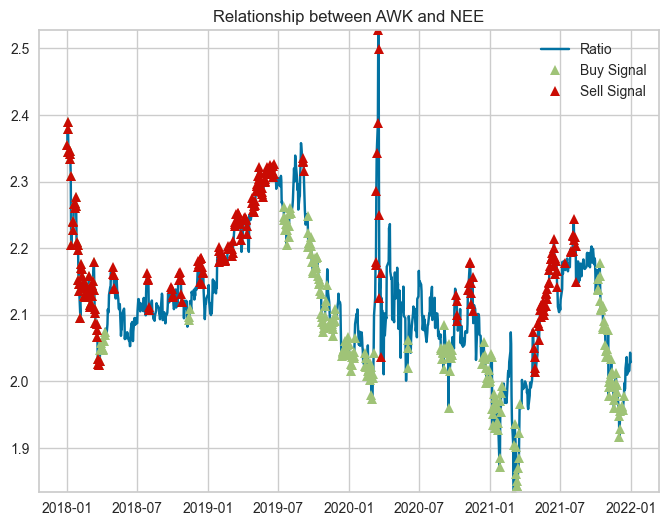

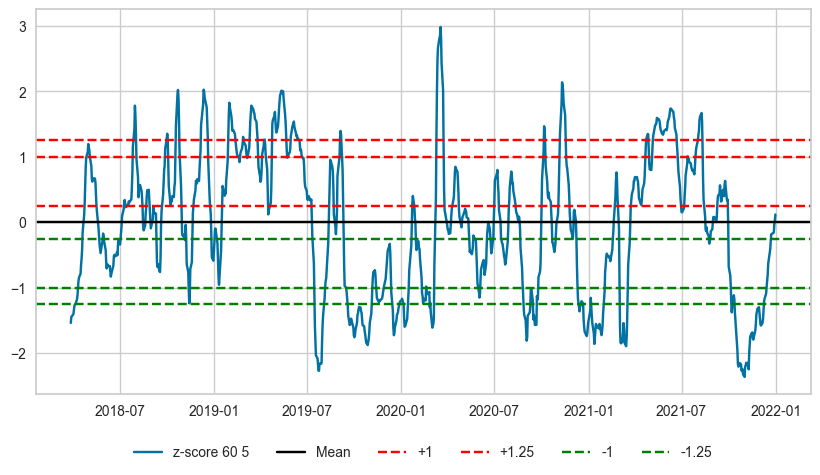

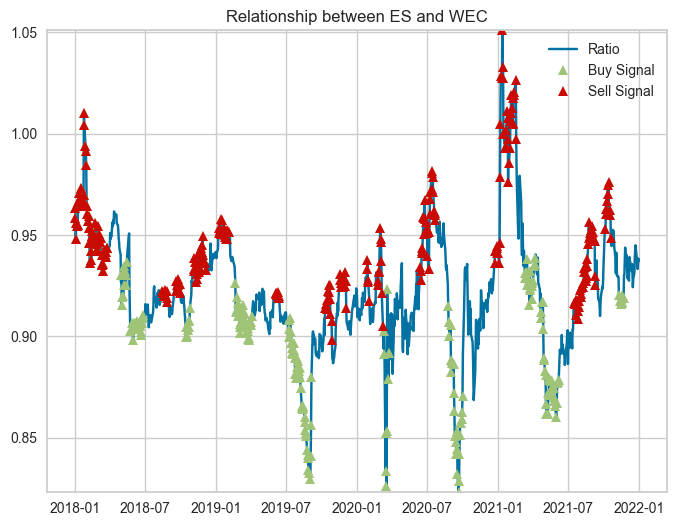

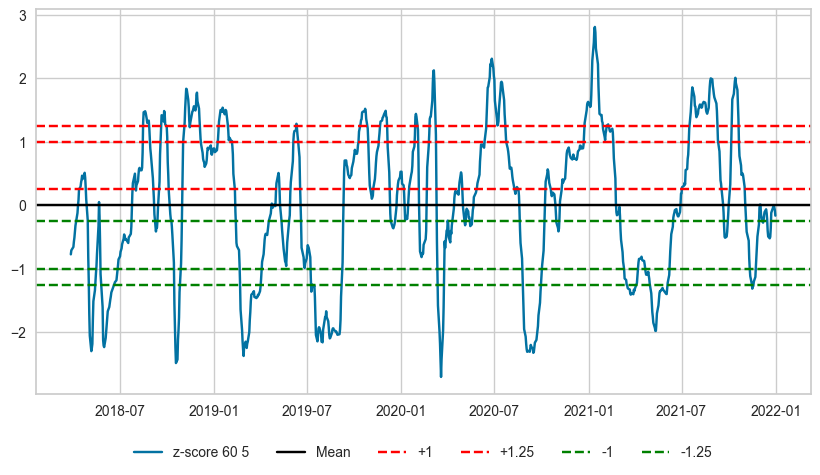

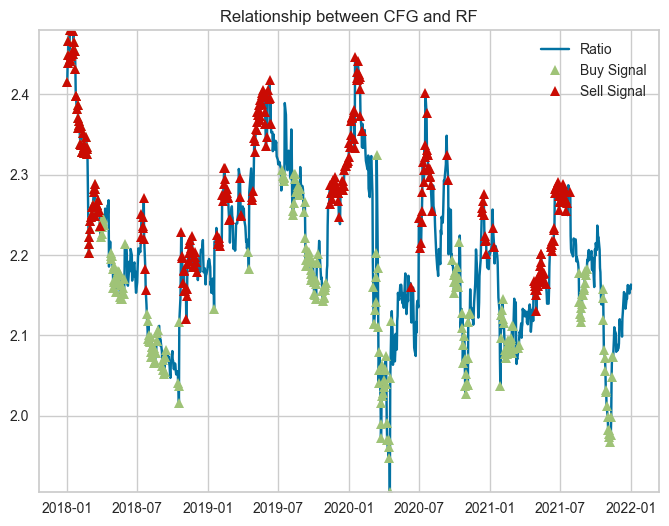

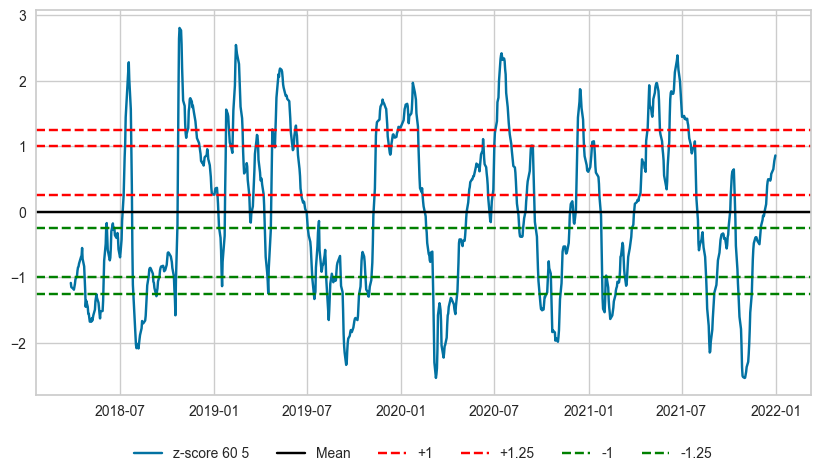

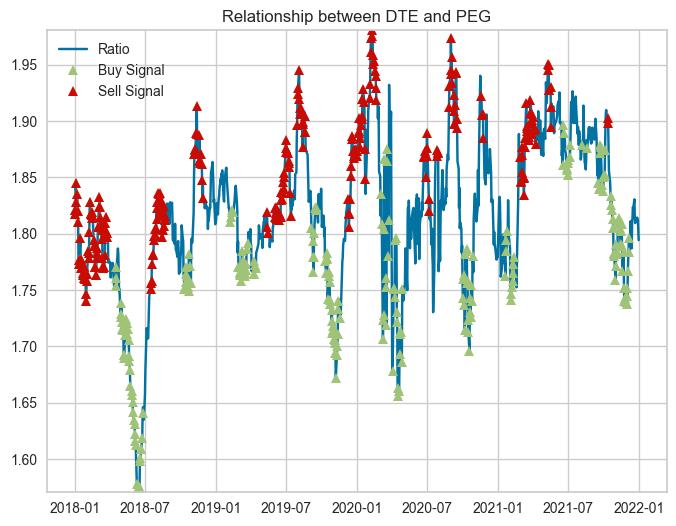

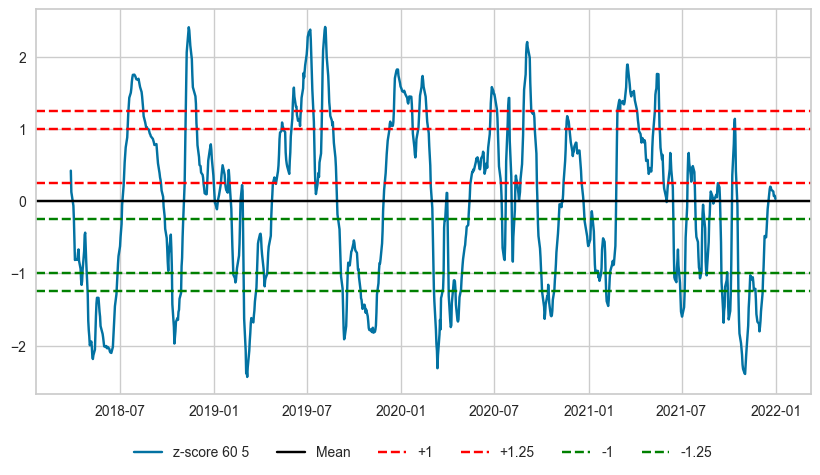

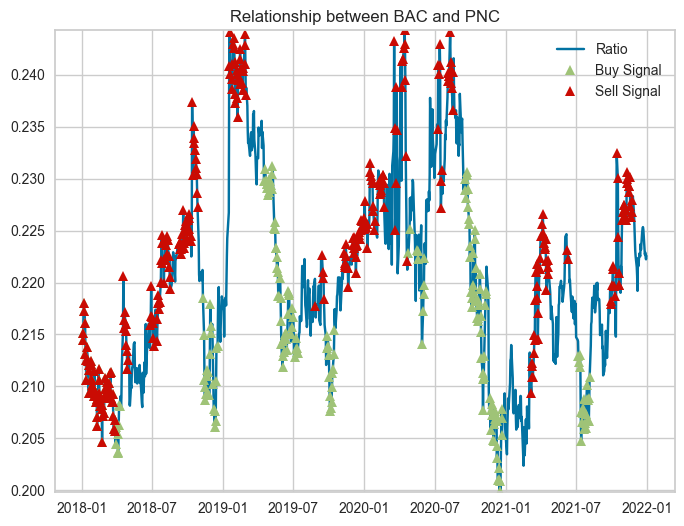

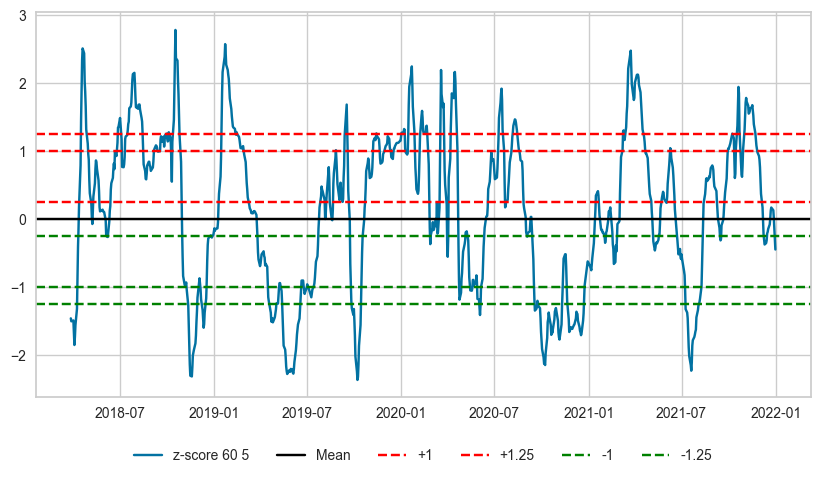

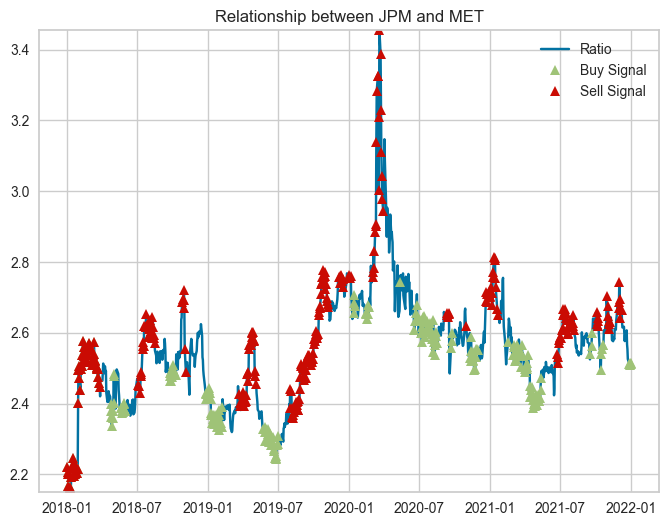

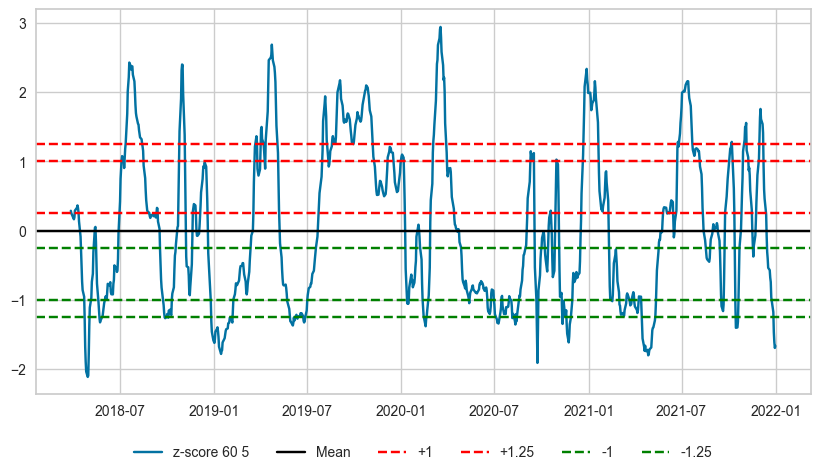

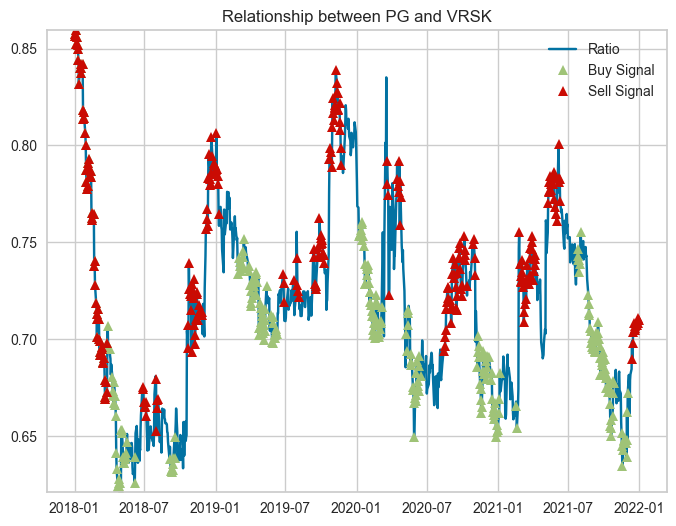

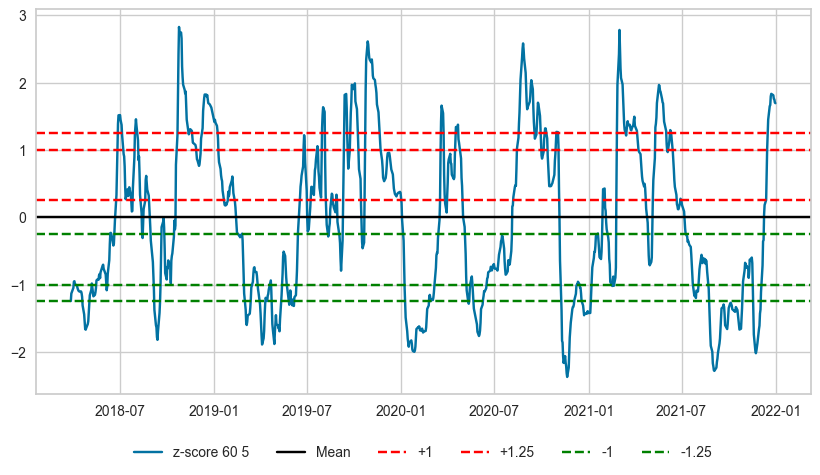

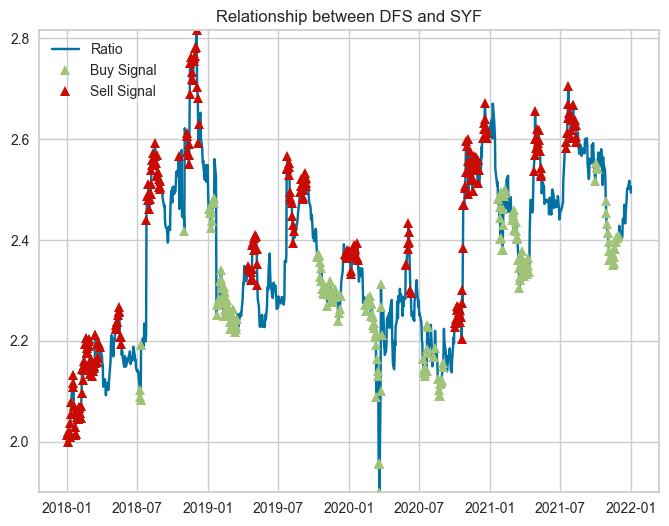

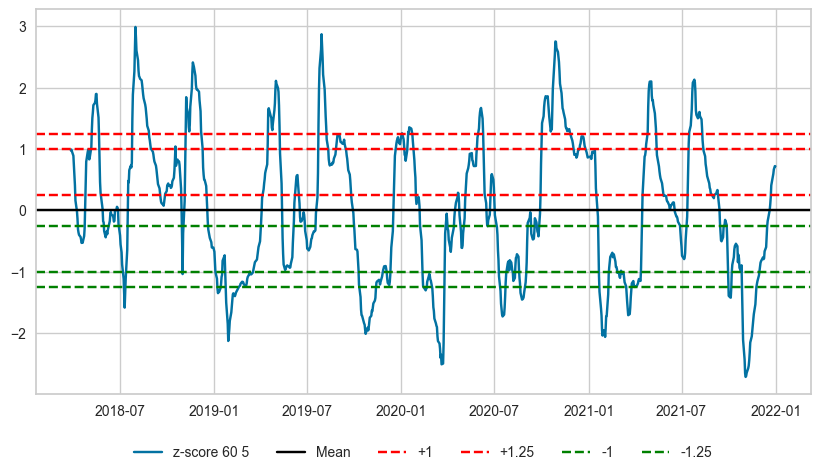

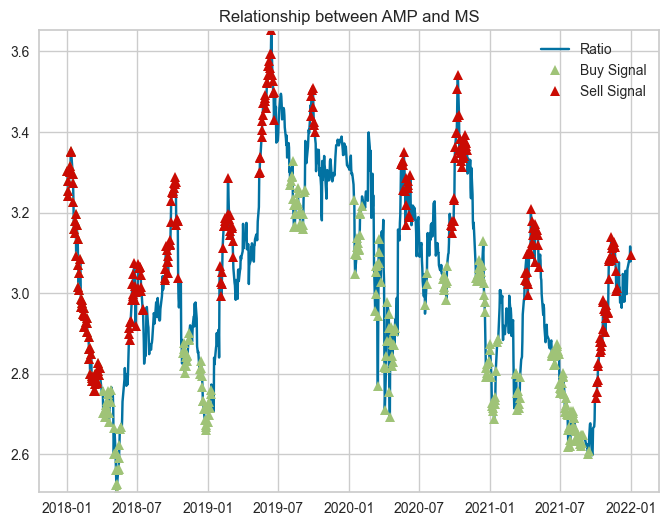

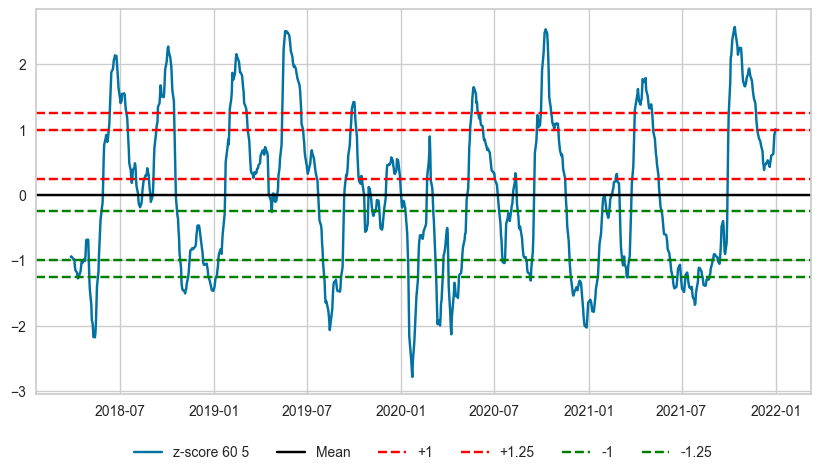

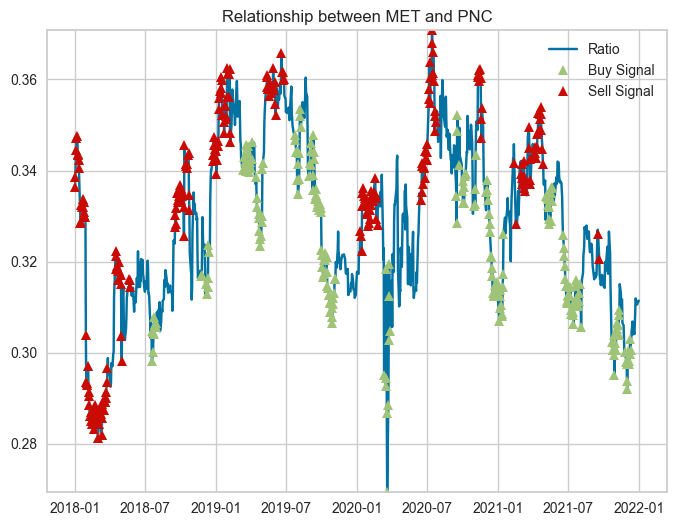

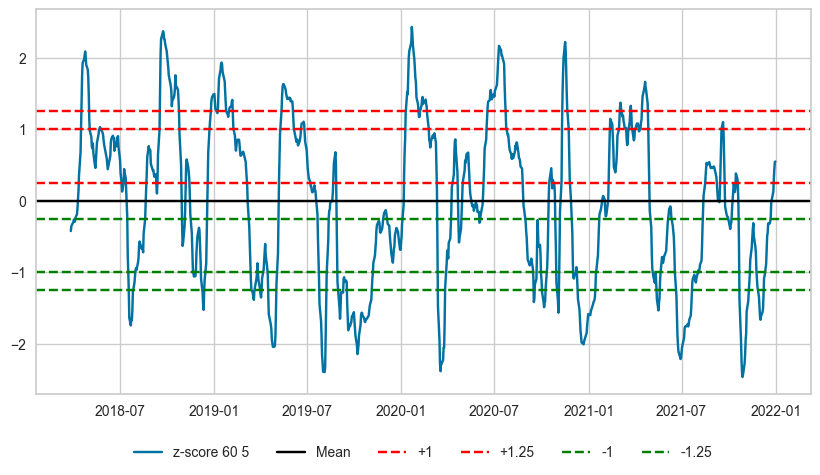

In [4]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = data[pair[0]]
    stock_2 = data[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()


            plt.figure(figsize=(10, 5))
            plt.plot(zscore_60_5)
            plt.axhline(0, color='black')
            plt.axhline(1, color='red', linestyle='--')
            plt.axhline(1.25, color='red', linestyle='--')
            plt.axhline(-1, color='green', linestyle='--')
            plt.axhline(-1.25, color='green', linestyle='--')
            plt.axhline(0.25, color='red', linestyle='--')
            plt.axhline(-0.25, color='green', linestyle='--')
            plt.legend(['z-score 60 5', 'Mean', '+1','+1.25','-1','-1.25'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
            plt.show()

In [5]:
trading_pairs = top_10_pairs.copy()
print(top_10_pairs)
print(trading_pairs)

[('AWK', 'NEE', 0.9868568115394872, 0.0021702962443593287, 0.8875227705044594, 0.00047915622637524516), ('ES', 'WEC', 0.9805179496276685, 0.0024463386112988073, 0.004369302557719054, 0.000846420301143742), ('CFG', 'RF', 0.9823147370618126, 0.013898508852412044, 0.5308970589810956, 0.0006392880800180128), ('DTE', 'PEG', 0.9673594718837637, 0.000884376996238171, 0.30832315414754896, 0.0002929419642600224), ('BAC', 'PNC', 0.984833159363554, 0.01739329281857443, 0.9154282930625082, 0.0015347259844459083), ('JPM', 'MET', 0.9685020620718218, 0.013915696687478907, 0.7826663417194497, 0.004255041314239258), ('PG', 'VRSK', 0.9645913152752947, 0.013567439644299777, 0.10223656125072028, 0.0019124531142389804), ('DFS', 'SYF', 0.9783016734527809, 0.01593526422457463, 0.824149846284554, 0.015336254177062974), ('AMP', 'MS', 0.9793277646520188, 0.027406236571223118, 0.9542769139825512, 0.014415377437221462), ('MET', 'PNC', 0.9690950745827942, 0.028273687948501807, 0.8872240116385294, 0.005260412110338

In [8]:
# Trading strategy
total_profit = 0
total_trade_vol = 0
total_order_fees = 0
transaction_list = []
trade_profit_list = []
trade_list = pd.DataFrame(columns=['StartDate','LongStock','LongStartPrice','ShortStock','ShortStartPrice','Status','ClosingDate','LongClosingPrice','ShortClosingPrice'])
number_of_trading_days = len(zscore_60_5) - 1
for pair in trading_pairs:
    # Cointgration test
    stock_1 = data[pair[0]]
    stock_2 = data[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60


        # only trade pairs with p-value < 0.05
        trade_volume = 1000
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        spec_amount_1, spec_amount_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        profit = 0
        trade_profit = 0
        # buy signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value < -1 and first_trade_day == 0: # long stock_1 and short stock_2 + get first trading day
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                total_trade_vol += trade_volume
                transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                new_row = pd.DataFrame({'StartDate':[first_trade_day],'LongStock':[pair[0]],'LongStartPrice':[stock_1.iloc[day]],'ShortStock':[pair[1]],
                                        'ShortStartPrice':[stock_2.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open']})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
                continue
                #list.append('day + quant1, quant2, stock_1.iloc, tradesum etc.') # Bei Verkauf dann auch stock_1.iloc und day etc. und Rendite berechnen wenn es geht
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < -1: # long stock_1 and short stock_2
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                total_trade_vol += trade_volume
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[0]],'LongStartPrice':[stock_1.iloc[day]],'ShortStock':[pair[1]],
                                        'ShortStartPrice':[stock_2.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open']})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > -0.25: # close trades
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                spec_amount_1 = 0
                spec_amount_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
                trade_profit = 0
         
            if zscore_value < -3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                print("risk mgmt, buy, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value < -1 : # close trades because it will take more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees 
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                print("risk mgmt, buy, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            if day == number_of_trading_days: # close open trades on the last day
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

        # reset values for sell signals
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        spec_amount_1, spec_amount_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        trade_profit = 0
        # sell signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value > 1 and first_trade_day == 0: # short stock_1 and long stock_2 + get first trading day
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                total_trade_vol += trade_volume
                transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[1]],'LongStartPrice':[stock_2.iloc[day]],'ShortStock':[pair[0]],
                                        'ShortStartPrice':[stock_1.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open']})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
                continue
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > 1: # short stock_1 and long stock_2
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                total_trade_vol += trade_volume
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[1]],'LongStartPrice':[stock_2.iloc[day]],'ShortStock':[pair[0]],
                                        'ShortStartPrice':[stock_1.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open']})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < 0.25: # close trades
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum                
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                spec_amount_1 = 0
                spec_amount_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
                trade_profit = 0
         
            if zscore_value > 3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum 
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))
                
                print("risk mgmt, sell, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value > 1 : # close trades, since it took more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))
                
                print("risk mgmt, sell, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            if day == number_of_trading_days: # close open trades on the last day
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
                    trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed'
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

    total_profit += profit
    total_profit_after_tax = total_profit * 0.73625 # 26.375% capital gains tax & solidarity surcharge

    print("Stock 1:", pair[0], "| Stock 2:", pair[1], "| Profit in Dollar before taxes:", round(profit,2))
print("Total profit in Dollar after taxes:", round(total_profit_after_tax,2))
print("Total order fees:", round(total_order_fees,2))
print("Total trade volume:", total_trade_vol)
#transaction_list
#trade_profit_list
    

Stock 1: AWK | Stock 2: NEE | Profit in Dollar before taxes: 48069.79
Stock 1: ES | Stock 2: WEC | Profit in Dollar before taxes: 29361.32
Stock 1: CFG | Stock 2: RF | Profit in Dollar before taxes: 9215.73
Stock 1: DTE | Stock 2: PEG | Profit in Dollar before taxes: 25505.13
Stock 1: BAC | Stock 2: PNC | Profit in Dollar before taxes: 39443.55
Stock 1: JPM | Stock 2: MET | Profit in Dollar before taxes: 56942.49
Stock 1: PG | Stock 2: VRSK | Profit in Dollar before taxes: 65988.68
Stock 1: DFS | Stock 2: SYF | Profit in Dollar before taxes: 38501.08
Stock 1: AMP | Stock 2: MS | Profit in Dollar before taxes: 62403.12
Stock 1: MET | Stock 2: PNC | Profit in Dollar before taxes: 31872.24
Total profit in Dollar after taxes: 299876.93
Total order fees: 92965.18
Total trade volume: 4518000


In [35]:
trade_list = trade_list[trade_list['StartDate']!= trade_list['ClosingDate']]
trade_volume = 500
orderfeeabs = 1
orderfeepercentage = 00
taxes = 0.26375
trade_list['GrossProfit'] = (trade_volume/trade_list['LongStartPrice'])*(trade_list['LongClosingPrice']-trade_list['LongStartPrice'])+ (trade_volume/trade_list['ShortStartPrice'])*(trade_list['ShortStartPrice']-trade_list['ShortClosingPrice'])
trade_list['NetProfit'] = (trade_list['GrossProfit'] *(1-orderfeepercentage) - orderfeeabs)*(1-taxes)
trade_list['ReturnRate'] = trade_list['NetProfit']/trade_volume/2
trade_list['ReturnRatePA'] = trade_list['ReturnRate']*252/(trade_list['ClosingDate']-trade_list['StartDate'])
total_gross = sum(trade_list['GrossProfit'])
total_net = sum(trade_list['NetProfit'])
rate_pa = trade_list['ReturnRatePA'].mean()
print(total_gross)
print(total_net)
print(rate_pa)
trade_list
#trade_list.to_excel('Trade_list.xlsx', index=False)


48547.93226682979
32419.246381453606
0.18440164698262426


,StartDate,LongStock,LongStartPrice,ShortStock,ShortStartPrice,Status,ClosingDate,LongClosingPrice,ShortClosingPrice,return_before_taxes,gross_return,GrossProfit,NetProfit,ReturnRate,ReturnRatePA
0,59,AWK,75.569229,NEE,36.905239,closed,75,77.877525,36.568634,39.666245,39.666245,19.833122,13.865886,0.013866,0.218388
1,60,AWK,76.444160,NEE,37.146317,closed,75,77.877525,36.568634,34.302024,34.302024,17.151012,11.891183,0.011891,0.199772
2,61,AWK,75.578522,NEE,36.927979,closed,75,77.877525,36.568634,40.149697,40.149697,20.074849,14.043857,0.014044,0.252789
3,62,AWK,75.541290,NEE,36.843826,closed,75,77.877525,36.568634,38.395752,38.395752,19.197876,13.398186,0.013398,0.259719
4,63,AWK,75.578522,NEE,36.918880,closed,75,77.877525,36.568634,39.905662,39.905662,19.952831,13.954022,0.013954,0.293034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4513,832,PNC,173.367340,MET,60.506046,closed,837,182.043488,61.315491,36.666969,36.666969,18.333484,12.761778,0.012762,0.643194
4514,833,PNC,175.509613,MET,60.506046,closed,837,182.043488,61.315491,23.850105,23.850105,11.925053,8.04357,0.008044,0.506745
4515,834,PNC,178.761932,MET,61.055313,closed,837,182.043488,61.315491,14.095783,14.095783,7.047891,4.45276,0.004453,0.374032
4516,934,PNC,185.190872,MET,60.380501,closed,939,190.660751,60.028313,35.369252,35.369252,17.684626,12.284056,0.012284,0.619116


In [19]:
# transaction history
transaction = transaction_list.copy()
df = pd.DataFrame(transaction)
df.columns = ['day', 'stock 1', 'price stock 1', 'stock 2', 'price stock 2', 'trade sum', 'trade profit', 'total profit per pair']
df = df.fillna(0)
df['open/close'] = df['trade sum'].apply(lambda x: 'open' if x == 0 else 'close')
df = df[['open/close'] + [col for col in df.columns if col != 'open/close']]
trade_sum_check = df['trade sum'].sum()
print(trade_sum_check)
df
#df.head(80)
#df[df['open/close']!= 'close']

4518000.0


,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,open,59,AWK,75.569229,NEE,36.905239,0.0,0.000000,0.000000
1,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
2,open,219,AWK,86.174614,NEE,41.179283,0.0,0.000000,0.000000
3,close,224,AWK,87.952194,NEE,41.204647,3000.0,48.776784,-132.173429
4,open,385,AWK,110.495125,NEE,48.844002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
427,close,732,MET,45.298004,PNC,134.285278,9000.0,1013.967056,29157.383746
428,open,784,MET,53.645035,PNC,156.997986,0.0,0.000000,0.000000
429,close,837,MET,61.315491,PNC,182.043488,33000.0,2709.065432,31866.449178
430,open,934,MET,60.380501,PNC,185.190872,0.0,0.000000,0.000000


In [20]:
# profit history
avg_profit = trade_profit_list.copy()
data = pd.DataFrame(avg_profit)
data.columns = ['trade sum', 'trade profit before taxes']
#print(data.isnull().any())
data['trade profit after taxes'] = data['trade profit before taxes'] * 0.73625
data['trade return before taxes'] = data['trade profit before taxes'] / data ['trade sum']
data['trade return after taxes'] = data['trade profit after taxes'] / data ['trade sum']
average_trade_profit_before_taxes = data['trade profit before taxes'].mean()
average_trade_profit_after_taxes = data['trade profit after taxes'].mean()
average_trade_return_before_taxes = data['trade return before taxes'].mean()
average_trade_return_after_taxes = data['trade return after taxes'].mean()
#total_profit_check = data['trade profit before taxes'].sum()
#print(total_profit_check)
#total_profit_check2 = data['trade profit after taxes'].sum()
#print(total_profit_check2)
trade_sum_check = data['trade sum'].sum()
print(trade_sum_check)
average_trade_return_before_taxes = round(average_trade_return_before_taxes * 100,2)
average_trade_return_after_taxes = round(average_trade_return_after_taxes * 100,2)
print("Average trade profit before taxes:", average_trade_profit_before_taxes)
print("Average trade profit after taxes:", average_trade_profit_after_taxes) # Man könnte noch Verlustverrechnung betrachten (Erwähnen in Nebensatz in Hausarbeit)
print("Average trade return before taxes:", average_trade_return_before_taxes, "%")
print("Average trade return after taxes:", average_trade_return_after_taxes, "%")
data
#data.head(51)

4518000
Average trade profit before taxes: 1885.6626209052235
Average trade profit after taxes: 1388.3191046414706
Average trade return before taxes: 7.39 %
Average trade return after taxes: 5.44 %


,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
0,9000,-180.950214,-133.224595,-0.020106,-0.014803
1,3000,48.776784,35.911908,0.016259,0.011971
2,15000,751.937762,553.614177,0.050129,0.036908
3,70000,12129.125836,8930.068897,0.173273,0.127572
4,16000,68.577100,50.489890,0.004286,0.003156
...,...,...,...,...,...
211,30000,-9405.287146,-6924.642661,-0.313510,-0.230821
212,28000,2042.886374,1504.075093,0.072960,0.053717
213,9000,1013.967056,746.533245,0.112663,0.082948
214,33000,2709.065432,1994.549424,0.082093,0.060441


In [21]:
negative_profit_rows = df[df['trade profit'] < 0]
open_trade_indices = negative_profit_rows.index - 1
open_trade_rows = df.loc[open_trade_indices]
result_df = pd.concat([open_trade_rows, negative_profit_rows])
result_df = result_df.sort_index()
result_df_sorted = result_df.reset_index(drop=True)
result_df_sorted
#result_df_sorted.head(50)

,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,open,59,AWK,75.569229,NEE,36.905239,0.0,0.000000,0.000000
1,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
2,open,59,CFG,35.106281,RF,15.706021,0.0,0.000000,0.000000
3,close,106,CFG,35.242458,RF,16.006739,34000.0,-314.415445,-314.415445
4,open,143,CFG,34.061768,RF,16.021500,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
61,close,128,MET,37.646282,PNC,119.793869,16000.0,-730.365028,33408.240375
62,open,179,MET,40.667572,PNC,124.107941,0.0,0.000000,0.000000
63,close,209,MET,35.385399,PNC,111.496552,28000.0,-1478.434150,31929.806225
64,open,509,MET,47.771610,PNC,146.242065,0.0,0.000000,0.000000


In [54]:
negative_values = df[df['trade profit'] < 0]
negative_values_reset = negative_values.reset_index(drop=True)
negative_values_reset

,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
1,close,106,CFG,35.242458,RF,16.006739,34000.0,-314.415445,-314.415445
2,close,203,CFG,30.589903,RF,14.248387,33000.0,-3847.563368,-4161.978812
3,close,265,CFG,30.113497,RF,13.482739,1000.0,-16.917953,-4178.896766
4,close,988,CFG,45.545689,RF,21.563187,20000.0,-1179.015127,10108.762595
5,close,256,CFG,27.942221,RF,12.895009,28000.0,-2642.333843,7653.883724
6,close,298,CFG,30.486607,RF,13.824777,19000.0,-25.577252,7628.306473
7,close,620,CFG,23.319942,RF,11.203826,1000.0,-124.693669,9021.819823
8,close,900,CFG,41.089035,RF,18.649633,53000.0,-3161.543219,9215.731823
9,close,593,DTE,78.545097,PEG,43.351467,17000.0,-319.927744,5902.537039


In [55]:
check_negative_values = data[data['trade profit before taxes'] < 0]
check_negative_values_reset = check_negative_values.reset_index(drop=True)
check_negative_values_reset

,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
0,9000,-180.950214,-133.224595,-0.020106,-0.014803
1,34000,-314.415445,-231.488371,-0.009248,-0.006808
2,33000,-3847.563368,-2832.768530,-0.116593,-0.085841
3,1000,-16.917953,-12.455843,-0.016918,-0.012456
4,20000,-1179.015127,-868.049887,-0.058951,-0.043402
5,28000,-2642.333843,-1945.418292,-0.094369,-0.069479
6,19000,-25.577252,-18.831252,-0.001346,-0.000991
7,1000,-124.693669,-91.805714,-0.124694,-0.091806
8,53000,-3161.543219,-2327.686195,-0.059652,-0.043919
9,17000,-319.927744,-235.546802,-0.018819,-0.013856
